In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sphincter.data_preparation import load_prepared_data
import os
import arviz as az

In [2]:
PLOTS_DIR = os.path.join("..", "plots")
IDATA_PATH = os.path.join("..", "inferences", "hypertension", "idata")
raw = pd.read_csv("../data/raw/hyper_challenge.csv")
prepped = load_prepared_data("../data/prepared/hypertension.json")

In [3]:
msts = prepped.measurements
msts.head()

,age,treatment,mouse,vessel_type,corr_bp_diam,atanh_corr_bp_diam
168,adult,hyper1,11020,bulb,0.900308,1.473841
152,adult,hyper1,110321,bulb,-0.336590,-0.350242
192,adult,hyper1,121020,bulb,0.244380,0.249427
194,adult,hyper1,140920,bulb,0.372125,0.390887
148,adult,hyper1,160321,bulb,0.833789,1.200440


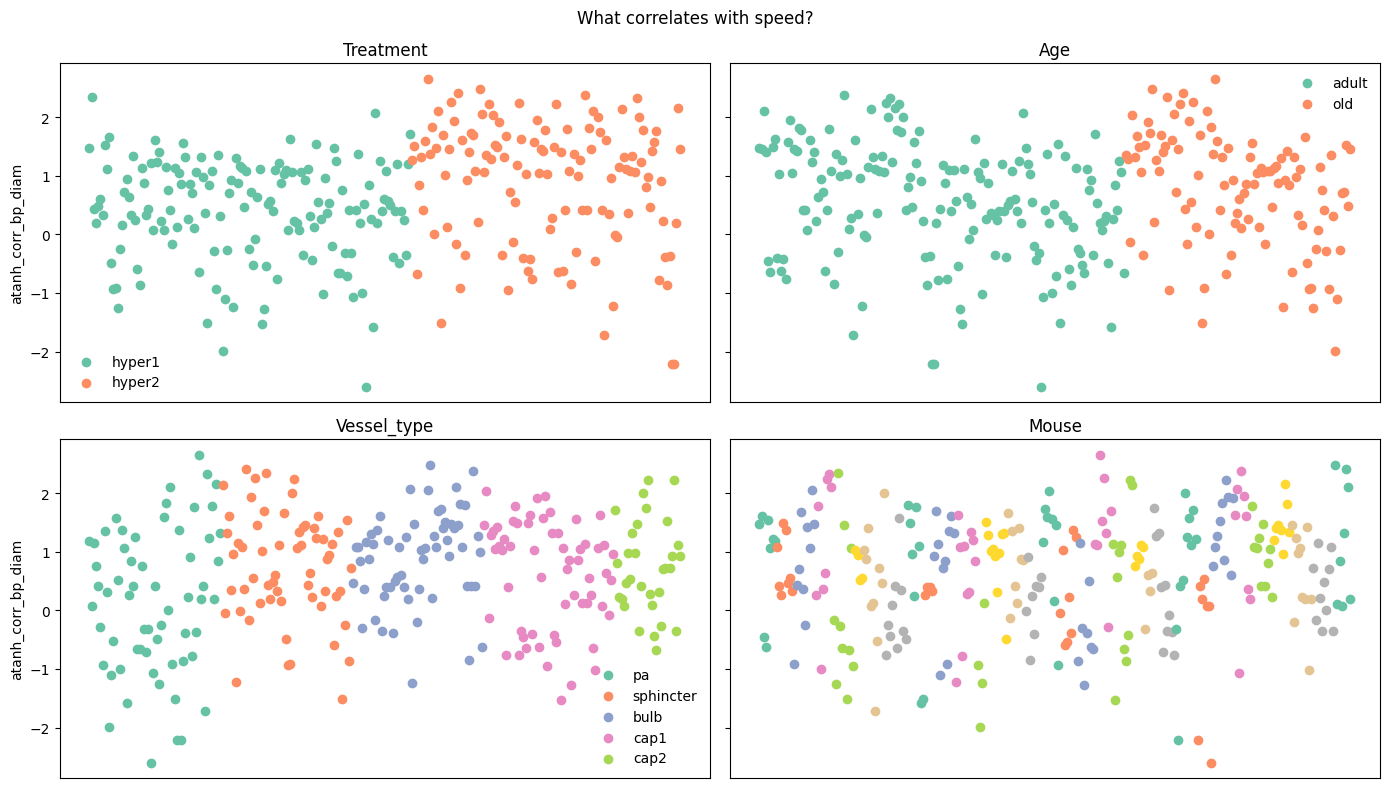

In [10]:
def plot_obs_cat(ax, obs, catcol, cmap, extra_obs=None, **scatter_kwargs):
    colors = list(cmap.colors)
    d_dict = {"obs": obs, "cat": catcol}
    if extra_obs is not None:
        d_dict["extra"] = extra_obs
    d = pd.DataFrame(d_dict).sort_values("cat").assign(x=np.linspace(0, 1, len(obs)))
    scts = []
    for i, (cat, subdf) in enumerate(d.groupby("cat", observed=True)):
        color = colors[i % len(colors)]
        scts.append(ax.scatter(subdf["x"], subdf["obs"], label=cat, color=color, **scatter_kwargs))
        if extra_obs is not None:
            scts.append(ax.scatter(subdf["x"], subdf["extra"], marker="x", label=extra_obs.name, color="black"))            
    return scts


obs = msts["atanh_corr_bp_diam"]
cmap = plt.get_cmap("Set2")

f, axes = plt.subplots(2, 2, figsize=[14, 8], sharey=True)
axes = axes.ravel()
for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
    catcol = msts[col]
    sct = plot_obs_cat(ax, obs, catcol, cmap)
    if col != "mouse":
        ax.legend(frameon=False);
    if i % 2 == 0:
        ax.set_ylabel("atanh_corr_bp_diam");
    ax.set_xticks([])
    ax.set_title(col.capitalize())
f.suptitle("What correlates with speed?");
f.tight_layout()
# f.savefig(os.path.join(PLOTS_DIR, "pulsatility-diameter-measurements.png"), bbox_inches="tight")

In [7]:
msts.sort_values("atanh_corr_bp_diam")

,age,treatment,mouse,vessel_type,corr_bp_diam,atanh_corr_bp_diam
34,adult,hyper1,260520,pa,-0.988968,-2.597274
27,adult,hyper2,260221,pa,-0.976462,-2.215216
35,adult,hyper2,260520,pa,-0.976014,-2.205681
28,old,hyper1,160421,pa,-0.963570,-1.993565
59,adult,hyper2,90321,pa,-0.937123,-1.713893
...,...,...,...,...,...,...
66,old,hyper1,70921,sphincter,0.981565,2.338686
165,adult,hyper2,270520,bulb,0.983107,2.382755
111,old,hyper2,310820,sphincter,0.983961,2.408915
177,old,hyper2,310820,bulb,0.985818,2.470893


In [11]:
idata = az.InferenceData.from_zarr(IDATA_PATH)

idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

In [12]:
az.summary(idata.sample_stats)

/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acceptance_rate,0.988,0.020,0.959,1.000,0.001,0.001,146.0,3622.0,1.03
diverging,0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
energy,-43.568,5.229,-52.830,-33.496,0.155,0.110,1148.0,2041.0,1.00
lp,54.995,3.916,48.140,62.290,0.112,0.079,1229.0,2279.0,1.00
n_steps,102.296,36.475,63.000,127.000,7.635,5.470,24.0,20.0,1.11
step_size,0.044,0.005,0.035,0.049,0.003,0.002,4.0,4.0,inf
tree_depth,6.392,0.506,6.000,7.000,0.148,0.108,12.0,11.0,1.24


In [26]:
az.summary(idata, var_names="~(_z)", filter_vars="regex")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_treatment[hyper1],-0.106,0.167,-0.446,0.190,0.005,0.003,1330.0,1699.0,1.00
a_treatment[hyper2],0.113,0.168,-0.210,0.433,0.005,0.004,1265.0,1532.0,1.01
a_vessel_type[pa],-0.156,0.114,-0.352,0.039,0.003,0.002,1466.0,2629.0,1.00
a_vessel_type[sphincter],0.045,0.096,-0.113,0.252,0.002,0.001,2386.0,2736.0,1.00
a_vessel_type[bulb],0.088,0.101,-0.097,0.276,0.003,0.002,1589.0,2519.0,1.00
a_vessel_type[cap1],-0.007,0.095,-0.194,0.169,0.002,0.001,2730.0,3045.0,1.00
a_vessel_type[cap2],0.025,0.102,-0.157,0.228,0.002,0.002,2507.0,2784.0,1.00
"a_vessel_type_treatment[pa, hyper1]",-0.064,0.097,-0.275,0.065,0.003,0.002,1264.0,1559.0,1.00
"a_vessel_type_treatment[pa, hyper2]",-0.015,0.074,-0.181,0.108,0.002,0.001,2570.0,2511.0,1.00
"a_vessel_type_treatment[sphincter, hyper1]",-0.006,0.067,-0.136,0.131,0.001,0.001,3688.0,3190.0,1.00


In [13]:
az.loo(idata)

Computed from 4000 posterior samples and 272 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -184.20    11.50
p_loo        8.74        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      272  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

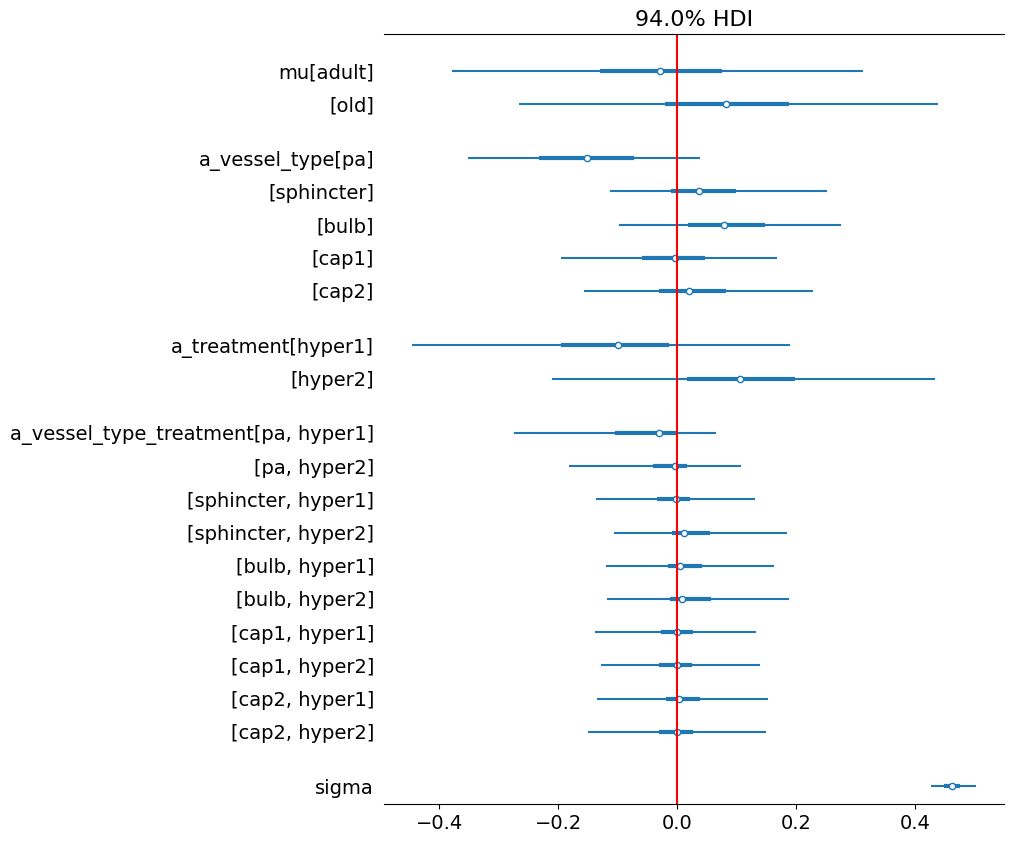

In [15]:
vars = ["mu", "a_vessel_type", "a_treatment", "a_vessel_type_treatment", "sigma"]
f, ax = plt.subplots(figsize=[8, 10], sharex=True)
az.plot_forest(
    idata,
    ax=ax,
    combined=True,
    var_names=vars,
);
ax.axvline(0, color="red")

0.026


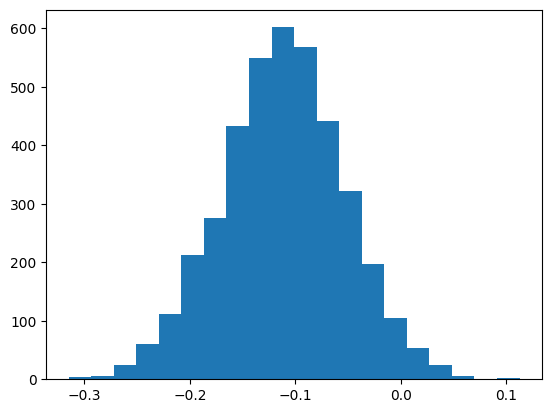

In [17]:
t = idata.posterior["mu"].sel(age="adult") - idata.posterior["mu"].sel(age="old")
print((t > 0).mean().values[()])

plt.hist(t.values.flatten(), bins=20);


0.985


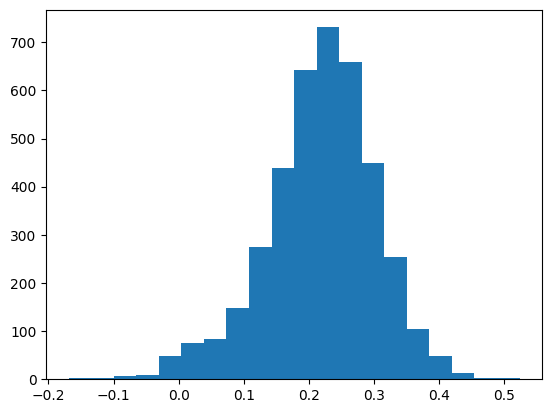

In [20]:
t = idata.posterior["a_treatment"].sel(treatment="hyper2") - idata.posterior["a_treatment"].sel(treatment="hyper1")

print((t > 0).mean().values[()])

plt.hist(t.values.flatten(), bins=20);

0.071


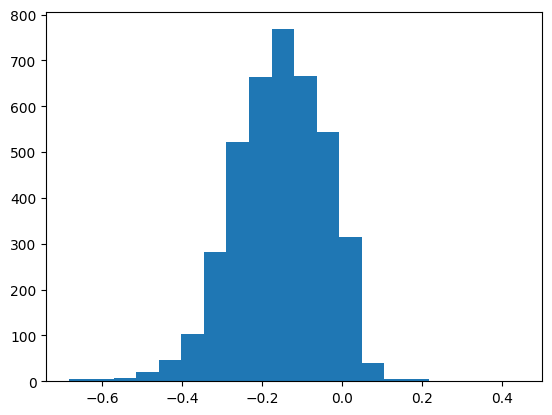

In [21]:
t = idata.posterior["a_vessel_type"].sel(vessel_type="pa")

print((t > 0).mean().values[()])

plt.hist(t.values.flatten(), bins=20);

0.31925


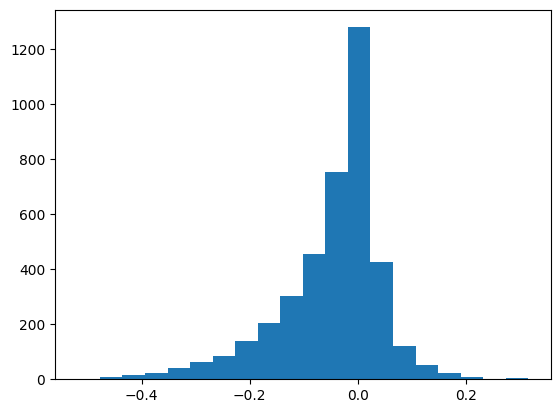

In [24]:
t = (
    idata.posterior["a_vessel_type_treatment"].sel(vessel_type="pa", treatment="hyper1")
    - idata.posterior["a_vessel_type_treatment"].sel(vessel_type="pa", treatment="hyper2")
)

print((t > 0).mean().values[()])

plt.hist(t.values.flatten(), bins=20);

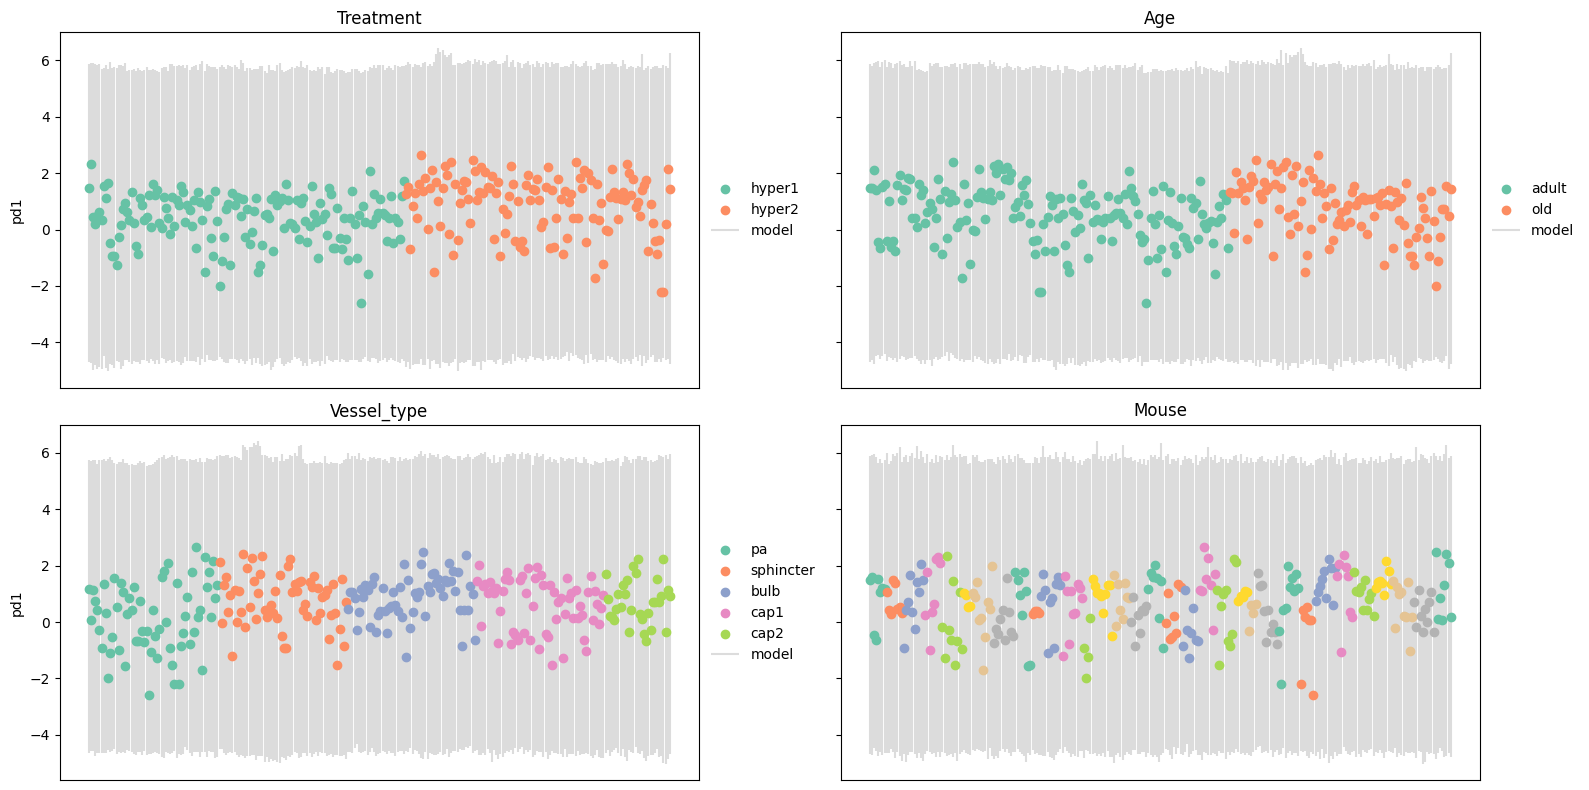

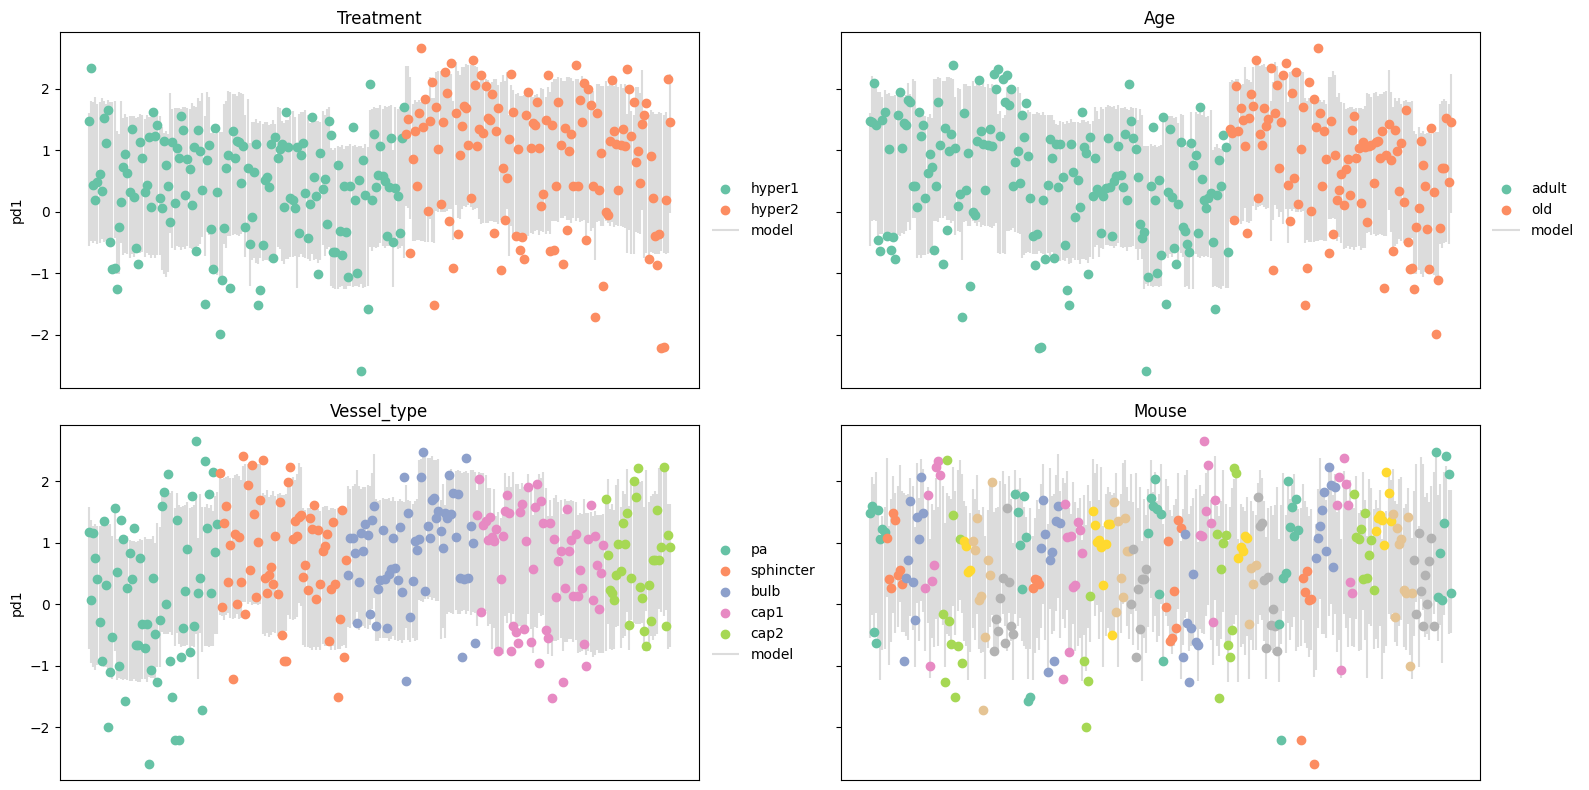

In [31]:
def plot_lines_cat(ax, yrep, catcol, cmap, **vlines_kwargs):
    colors = list(cmap.colors)
    d = pd.DataFrame(
        {
            "cat": catcol,
            "q1": yrep.quantile(0.01, dim=["chain", "draw"]).values,
            "q99": yrep.quantile(0.99, dim=["chain", "draw"]).values,
        }
    ).sort_values("cat").assign(x=np.linspace(0, 1, len(catcol)))
    linesets = []
    for i, (cat, subdf) in enumerate(d.groupby("cat", observed=True)):
        lines = ax.vlines(subdf["x"], subdf["q1"], subdf["q99"], color="gainsboro", **vlines_kwargs)
    return lines

def plot_ppc(axes, mts, obs, yrep, cmap):
    for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
        catcol = mts[col].cat.remove_unused_categories()
        scts = plot_obs_cat(ax, obs, catcol, cmap)
        lines = plot_lines_cat(ax, yrep, catcol, cmap, zorder=0, label="model")
        if col != "mouse":
            ax.legend(scts + [lines], list(catcol.cat.categories) + ["model"], frameon=False, bbox_to_anchor=[1,0.5], loc="center left");
        if i % 2 == 0:
            ax.set_ylabel("pd1");
        ax.set_xticks([])
        ax.set_title(col.capitalize())

cmap = plt.get_cmap("Set2")

for group, mode in zip(
    [idata.prior_predictive, idata.posterior_predictive], ["prior", "posterior"]
):
    yrep = group["yrep"]
    obs = msts["atanh_corr_bp_diam"]
    f, axes = plt.subplots(2, 2, figsize=[16, 8], sharey=True)
    axes = axes.ravel()
    axes = plot_ppc(axes, msts, obs, yrep, cmap)
    # f.suptitle(f"{mt.capitalize()} pulsatility measurements (first harmonic) vs {mode} simulations");
    f.tight_layout()
    # f.savefig(os.path.join(PLOTS_DIR, f"pulsatility-{mode}-check-{mt}.png"), bbox_inches="tight")